In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import nibabel as nib
import os
import random
from scipy.ndimage import label
from skimage import measure
import torch.nn.functional as F

In [2]:
import wandb
wandb.login(key='5b5ac44e005511998d206c41a19d85d5fe19ded9')

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: o24253 (o24253-iit-mandi) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

# Data Preprocessing
Converting 3D NIfTI volumes to aligned 2D slices, normalize
intensities

In [2]:
# Define Paths
input_dir = '/kaggle/input/synthrad/brain'   # Input dataset path
output_dir = '/kaggle/working/processed_data/'
output_mri_dir = os.path.join(output_dir, 'mri_slices/')
output_ct_dir = os.path.join(output_dir, 'ct_slices/')

# Create the output directories
os.makedirs(output_mri_dir, exist_ok=True)
os.makedirs(output_ct_dir, exist_ok=True)

# Normalization functions
def normalize_mri(slice_data):
    if np.max(slice_data) == np.min(slice_data):
        return np.zeros(slice_data.shape)
    return (slice_data - np.min(slice_data)) / (np.max(slice_data) - np.min(slice_data))

def normalize_ct(slice_data, window_min=-1000, window_max=1000):
    clipped_slice = np.clip(slice_data, window_min, window_max)
    
    return (clipped_slice - window_min) / (window_max - window_min)

# Data preprocessing (NIfTI to 2D slices, normalization)
for root, dirs, files in os.walk(input_dir):
    # Check for required files
    if 'mr.nii' in files and 'ct.nii' in files and 'mask.nii' in files:
        subject_id = os.path.basename(root).replace(" ", "_").replace("-", "_")

        # Paths
        mr_path = os.path.join(root, 'mr.nii')
        ct_path = os.path.join(root, 'ct.nii')
        mask_path = os.path.join(root, 'mask.nii')

        # Load NIfTI files
        mr_img = nib.load(mr_path)
        ct_img = nib.load(ct_path)
        mask_img = nib.load(mask_path)

        # Convert to numpy arrays
        mr_data = mr_img.get_fdata()
        ct_data = ct_img.get_fdata()
        mask_data = mask_img.get_fdata()

        # Apply the mask
        mr_data_masked = mr_data * mask_data
        ct_data_masked = ct_data * mask_data

        # Slice and save
        for i in range(mr_data_masked.shape[2]):
            mri_slice = mr_data_masked[:, :, i]
            ct_slice = ct_data_masked[:, :, i]
            nonzero_fraction = np.count_nonzero(mri_slice) / mri_slice.size
            
            if nonzero_fraction < 0.15:
                continue
                
            # Normalize
            mri_slice_norm = normalize_mri(mri_slice)
            ct_slice_norm = normalize_ct(ct_slice)

            # Save as .npy
            np.save(f'{output_mri_dir}/{subject_id}_slice_{i:03}.npy', mri_slice_norm.astype(np.float16))
            np.save(f'{output_ct_dir}/{subject_id}_slice_{i:03}.npy', ct_slice_norm.astype(np.float16))

print("\n Preprocessing complete! All slices saved.")



 Preprocessing complete! All slices saved.


In [3]:
mri_files = sorted(os.listdir(output_mri_dir))
ct_files = sorted(os.listdir(output_ct_dir))

print(f"Total MRI slices: {len(mri_files)}")
print(f"Total CT slices: {len(ct_files)}")


Total MRI slices: 30794
Total CT slices: 30794


# EDA

Intensity distribution

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


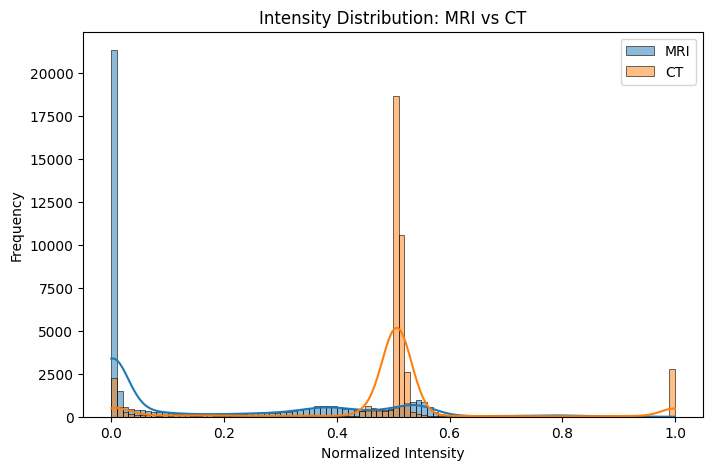

In [4]:
# Pick one random slice
idx = random.choice(range(len(mri_files)))

mri_slice = np.load(os.path.join(output_mri_dir, mri_files[idx]))
ct_slice = np.load(os.path.join(output_ct_dir, ct_files[idx]))

# Flatten the slices for histogram analysis
mri_flattened = mri_slice.flatten().astype('float32')
ct_flattened = ct_slice.flatten().astype('float32')

plt.figure(figsize=(8,5))
sns.histplot(mri_flattened, bins=100,kde=True, alpha=0.5, label="MRI")
sns.histplot(ct_flattened, bins=100,kde=True, alpha=0.5, label="CT")
plt.xlabel("Normalized Intensity")
plt.ylabel("Frequency")
plt.legend()
plt.title("Intensity Distribution: MRI vs CT")
plt.show()




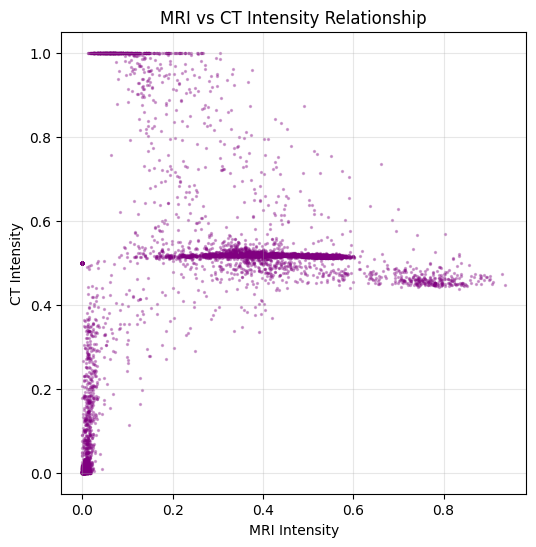

In [5]:
# Scatter Plot: MRI vs CT Intensities
sample_idx = np.random.choice(len(mri_flattened), size=10000, replace=False)

plt.figure(figsize=(6,6))
plt.scatter(mri_flattened[sample_idx], ct_flattened[sample_idx], 
            alpha=0.3, s=2, c='purple')
plt.xlabel("MRI Intensity")
plt.ylabel("CT Intensity")
plt.title("MRI vs CT Intensity Relationship")
plt.grid(True, alpha=0.3)
plt.show()

Brain Region Visualization

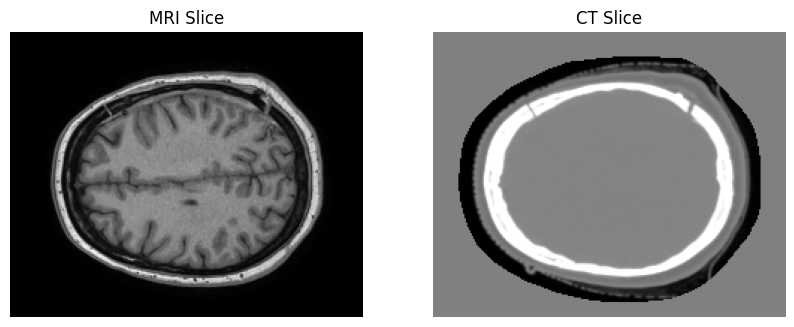

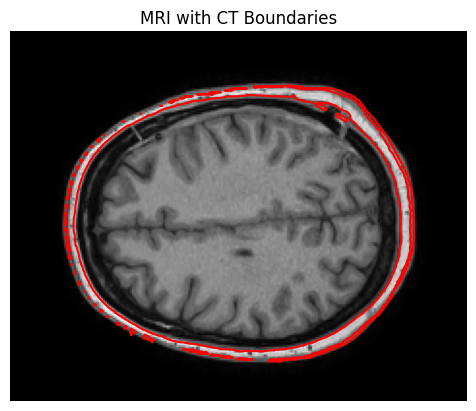

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(mri_slice, cmap='gray')
axs[0].set_title("MRI Slice"); axs[0].axis('off')

axs[1].imshow(ct_slice, cmap='gray')
axs[1].set_title("CT Slice"); axs[1].axis('off')
plt.show()

# Overlay CT contours on MRI
contours = measure.find_contours(ct_slice, 0.5)  # threshold ~0.5 after normalization
plt.imshow(mri_slice, cmap='gray')
for contour in contours:
    plt.plot(contour[:, 1], contour[:, 0], color='red')
plt.title("MRI with CT Boundaries")
plt.axis('off')
plt.show()

Modality contrasts

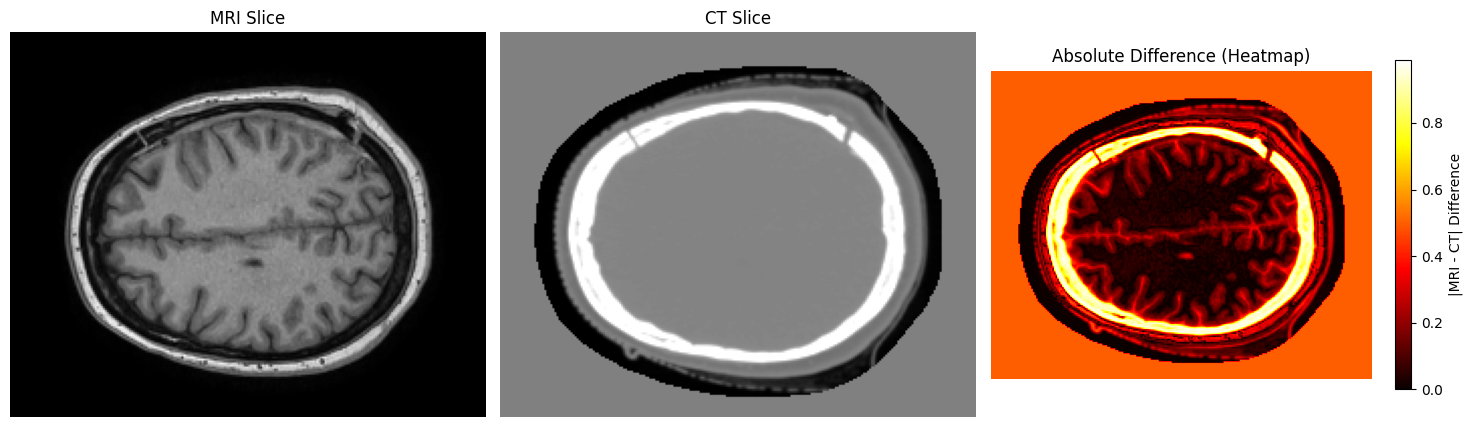

In [7]:
# Absolute Difference (Modality Contrast)
diff_slice = np.abs(mri_slice - ct_slice)

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(mri_slice, cmap='gray')
plt.title('MRI Slice')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(ct_slice, cmap='gray')
plt.title('CT Slice')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(diff_slice, cmap='hot')
plt.colorbar(label="|MRI - CT| Difference", shrink=0.7)
plt.title('Absolute Difference (Heatmap)')
plt.axis('off')

plt.tight_layout()
plt.show()



In [8]:
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms # Import the transforms module

class PairedImageDataset(Dataset):
    def __init__(self, mri_dir, ct_dir, filenames, img_size=(256, 256)):
        self.mri_dir = mri_dir
        self.ct_dir = ct_dir
        self.filenames = filenames
        
        # Define the resize transform
        self.transform = transforms.Resize(size=img_size, antialias=True)

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        filename = self.filenames[idx]
        mri_path = os.path.join(self.mri_dir, filename)
        ct_path = os.path.join(self.ct_dir, filename)

        mri_data = np.load(mri_path)
        ct_data = np.load(ct_path)

        # Convert to a float tensor and add a channel dimension [1, H, W]
        mri_tensor = torch.from_numpy(mri_data).float().unsqueeze(0)
        ct_tensor = torch.from_numpy(ct_data).float().unsqueeze(0)
        
        # Apply the resize transform
        mri_tensor_resized = self.transform(mri_tensor)
        ct_tensor_resized = self.transform(ct_tensor)

        return mri_tensor_resized, ct_tensor_resized

In [9]:
filenames = mri_files

# Shuffle the filenames list to ensure a random distribution of subjects/slices
random.seed(42)  # For reproducibility
random.shuffle(filenames)

# Define the split ratios
train_ratio = 0.7  # 70% for training
val_ratio = 0.1   # 10% for validation
test_ratio = 0.2  # 20% for testing

# Calculate the number of files for each split
total_files = len(filenames)
train_count = int(total_files * train_ratio)
val_count = int(total_files * val_ratio)
test_count = total_files - train_count - val_count # Ensure all files are included

# Split the filenames into their respective lists
train_filenames = filenames[:train_count]
val_filenames = filenames[train_count:train_count + val_count]
test_filenames = filenames[train_count + val_count:]

print(f"Total files: {total_files}")
print(f"Training files: {len(train_filenames)}")
print(f"Validation files: {len(val_filenames)}")
print(f"Test files: {len(test_filenames)}")

Total files: 30794
Training files: 21555
Validation files: 3079
Test files: 6160


In [10]:
# Define your directories where the preprocessed .npy files are saved
mri_dir = output_mri_dir
ct_dir = output_ct_dir

# Create the Dataset objects for each split
train_dataset = PairedImageDataset(mri_dir, ct_dir, train_filenames)
val_dataset = PairedImageDataset(mri_dir, ct_dir, val_filenames)
test_dataset = PairedImageDataset(mri_dir, ct_dir, test_filenames)

# Create the DataLoader objects
batch_size = 128 # Adjust this based on your GPU's memory
train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dl = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train Dataloader batches: {len(train_dl)}")
print(f"Validation Dataloader batches: {len(val_dl)}")
print(f"Test Dataloader batches: {len(test_dl)}")

Train Dataloader batches: 169
Validation Dataloader batches: 25
Test Dataloader batches: 49


In [11]:
device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [12]:
# Get a single batch of data from the DataLoader
mri_batch, ct_batch = next(iter(train_dl))

# Check the shape of the tensors
print(f"Shape of MRI batch: {mri_batch.shape}")
print(f"Shape of CT batch: {ct_batch.shape}")

Shape of MRI batch: torch.Size([128, 1, 256, 256])
Shape of CT batch: torch.Size([128, 1, 256, 256])


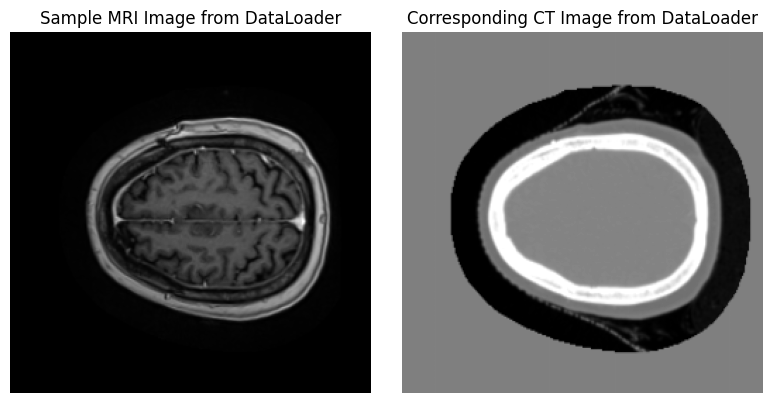

In [13]:

# Perform a quick visualization of the first image in the batch
# to ensure it looks correct
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

# Squeeze removes the channel dimension for plotting
axs[0].imshow(mri_batch[0].squeeze(), cmap='gray')
axs[0].set_title("Sample MRI Image from DataLoader")
axs[0].axis("off")

axs[1].imshow(ct_batch[0].squeeze(), cmap='gray')
axs[1].set_title("Corresponding CT Image from DataLoader")
axs[1].axis("off")

plt.tight_layout()
plt.show()

#  Model Development

In [14]:
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet34

# -------------------------------
# U-Net with ResNet34 encoder
# -------------------------------
class UpBlock(nn.Module):
    def __init__(self, in_ch, skip_ch, out_ch):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False)
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch + skip_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x, skip):
        x = self.up(x)
        x = torch.cat([x, skip], dim=1)
        return self.conv(x)

class ResNetUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, pretrained=True):
        super().__init__()
        base = resnet34(weights="IMAGENET1K_V1" if pretrained else None)

        # adapt first conv for MRI (1 channel input)
        if in_channels != 3:
            w = base.conv1.weight
            base.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
            if pretrained:
                base.conv1.weight.data = w.mean(dim=1, keepdim=True)

        # encoder
        self.enc0 = nn.Sequential(base.conv1, base.bn1, base.relu)  # 64 @ /2
        self.pool = base.maxpool
        self.enc1 = base.layer1   # 64 @ /4
        self.enc2 = base.layer2   # 128 @ /8
        self.enc3 = base.layer3   # 256 @ /16
        self.enc4 = base.layer4   # 512 @ /32

        # decoder
        self.up4 = UpBlock(512, 256, 256)   # /16
        self.up3 = UpBlock(256, 128, 128)   # /8
        self.up2 = UpBlock(128, 64, 64)     # /4
        self.up1 = UpBlock(64, 64, 32)      # /2
        self.up0 = nn.Sequential(           # NEW block: back to /1
            nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False),
            nn.Conv2d(32, 16, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True)
        )

        # final conv
        self.final = nn.Conv2d(16, out_channels, kernel_size=1)

    def forward(self, x):
        e0 = self.enc0(x)       # /2
        p = self.pool(e0)       # /4
        e1 = self.enc1(p)       # /4
        e2 = self.enc2(e1)      # /8
        e3 = self.enc3(e2)      # /16
        e4 = self.enc4(e3)      # /32

        d4 = self.up4(e4, e3)   # /16
        d3 = self.up3(d4, e2)   # /8
        d2 = self.up2(d3, e1)   # /4
        d1 = self.up1(d2, e0)   # /2
        d0 = self.up0(d1)       # /1 (same as input)

        return torch.tanh(self.final(d0))

# -------------------------------
# PatchGAN Discriminator (simple)
# -------------------------------
class PatchDiscriminator(nn.Module):
    def __init__(self, in_channels=2):  # MRI + sCT concatenated
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 1, 4, stride=1, padding=1)  # patch output
        )
    def forward(self, x, y):
        return self.model(torch.cat([x, y], dim=1))

In [15]:
# -------------------------------
# Training loop (minimal)
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

G = ResNetUNet(in_channels=1, out_channels=1).to(device)
D = PatchDiscriminator(in_channels=2).to(device)

# losses
criterion_L1 = nn.L1Loss().to(device)
criterion_GAN = nn.BCEWithLogitsLoss().to(device)

# optimizers
opt_G = optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))
opt_D = optim.Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.999))

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 158MB/s] 


In [16]:
from torchsummary import summary
summary(G,input_size=(1,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           3,136
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

In [17]:
summary(D, input_size=[(1, 256, 256), (1, 256, 256)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           2,112
         LeakyReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3          [-1, 128, 64, 64]         131,200
       BatchNorm2d-4          [-1, 128, 64, 64]             256
         LeakyReLU-5          [-1, 128, 64, 64]               0
            Conv2d-6          [-1, 256, 32, 32]         524,544
       BatchNorm2d-7          [-1, 256, 32, 32]             512
         LeakyReLU-8          [-1, 256, 32, 32]               0
            Conv2d-9            [-1, 1, 31, 31]           4,097
Total params: 662,721
Trainable params: 662,721
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 16384.00
Forward/backward pass size (MB): 34.01
Params size (MB): 2.53
Estimated Total Size (MB): 16420.54
----------------------------------

In [19]:
# Load checkpoint
checkpoint = torch.load("/kaggle/input/pixx/pytorch/default/1/pix2pixcharb78.pth", map_location=device)

# Restore models
G.load_state_dict(checkpoint["G_state_dict"])
D.load_state_dict(checkpoint["D_state_dict"])

# Restore optimizers 
opt_G.load_state_dict(checkpoint["opt_G_state_dict"])
opt_D.load_state_dict(checkpoint["opt_D_state_dict"])

In [ ]:
# Initialize tracking lists
train_G_losses = []
train_D_losses = []
train_GAN_losses = []
train_L1_losses = []
val_losses = []

epochs = 100
lambda_L1 = 100
best_val_loss = float("inf")  # initialize with very large value
save_path = "checkpoints"
os.makedirs(save_path, exist_ok=True)

G.train()
D.train()

for epoch in range(epochs):
    # accumulators for this epoch
    epoch_G_loss = 0.0
    epoch_D_loss = 0.0
    epoch_GAN_loss = 0.0
    epoch_L1_loss = 0.0
    num_batches = 0

    for i, (real_A, real_B) in enumerate(train_dl):  # MRI = real_A, sCT = real_B
        real_A, real_B = real_A.to(device), real_B.to(device)

        #for j in range(2):  # train Generator more times than Discriminator
            # -----------------
            # Train Generator
            # -----------------
        opt_G.zero_grad()
        fake_B = G(real_A)

            # GAN loss (fool discriminator)
        pred_fake = D(real_A, fake_B)
        valid = torch.ones_like(pred_fake, device=device)
        loss_GAN = criterion_GAN(pred_fake, valid)

            # L1 reconstruction loss
        loss_L1 = criterion_L1(fake_B, real_B) * lambda_L1

            # total generator loss
        loss_G = loss_GAN + loss_L1
        loss_G.backward()
        opt_G.step()

        # -----------------
        # Train Discriminator
        # -----------------
        opt_D.zero_grad()

        # Real
        pred_real = D(real_A, real_B)
        loss_real = criterion_GAN(pred_real, valid)

        # Fake
        fake = torch.zeros_like(pred_real, device=device)
        pred_fake = D(real_A, fake_B.detach())
        loss_fake = criterion_GAN(pred_fake, fake)

        loss_D = 0.5 * (loss_real + loss_fake)
        loss_D.backward()
        opt_D.step()

        # accumulate losses
        epoch_G_loss += loss_G.item()
        epoch_D_loss += loss_D.item()
        epoch_GAN_loss += loss_GAN.item()
        epoch_L1_loss += loss_L1.item()
        num_batches += 1

        if i % 80 == 0:
            print(f"[Epoch {epoch+1}/{epochs}] [Batch {i}/{len(train_dl)}] "
                  f"Loss_D: {loss_D.item():.4f} | Loss_G: {loss_G.item():.4f} "
                  f"(GAN: {loss_GAN.item():.4f}, L1: {loss_L1.item():.4f})")

    # Average training losses per epoch
    epoch_G_loss /= num_batches
    epoch_D_loss /= num_batches
    epoch_GAN_loss /= num_batches
    epoch_L1_loss /= num_batches

    train_G_losses.append(epoch_G_loss)
    train_D_losses.append(epoch_D_loss)
    train_GAN_losses.append(epoch_GAN_loss)
    train_L1_losses.append(epoch_L1_loss)

    # -----------------
    # Validation loop
    # -----------------
    G.eval()
    val_loss = 0.0
    with torch.no_grad():
        for real_A, real_B in val_dl:
            real_A, real_B = real_A.to(device), real_B.to(device)
            fake_B = G(real_A)
            val_loss += criterion_L1(fake_B, real_B).item()
    val_loss /= len(val_dl)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}: "
          f"Train_G: {epoch_G_loss:.4f}, Train_D: {epoch_D_loss:.4f}, "
          f"Val_L1: {val_loss:.4f}")

    # -----------------
    # Save best model checkpoint
    # -----------------
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(
            {
                "epoch": epoch+1,
                "G_state_dict": G.state_dict(),
                "D_state_dict": D.state_dict(),
                "opt_G_state_dict": opt_G.state_dict(),
                "opt_D_state_dict": opt_D.state_dict(),
                "val_loss": best_val_loss,
            },
            os.path.join(save_path, "best_model1.pth")
        )
        print(f"Saved best model at epoch {epoch+1} with val_loss {val_loss:.4f}")

    G.train()

print("Training finished")

In [ ]:
# ------------------------------------
# Plotting Loss Curves
# ------------------------------------
import matplotlib.pyplot as plt
x=range(1, 80)
plt.figure(figsize=(12,6))
plt.plot(x,train_G_losses, label="Generator Loss")
plt.plot(x,train_D_losses, label="Discriminator Loss")

plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Training  Losses")
plt.legend()
plt.show()

# Evaluation

In [20]:
# -------------------------------
# Test function
# -------------------------------
def test_model(generator, test_dataloader, device="cuda", num_samples=3):
    generator.eval()
    generator.to(device)

    with torch.no_grad():
        for i, (real_A, real_B) in enumerate(test_dataloader):  # real_A: MRI, real_B: CT
            real_A, real_B = real_A.to(device), real_B.to(device)

            # Generate fake CT from MRI
            fake_B = generator(real_A)

            # Move to CPU for plotting
            real_A = real_A.cpu().squeeze().numpy()
            real_B = real_B.cpu().squeeze().numpy()
            fake_B = fake_B.cpu().squeeze().numpy()

            # Plot a few examples
            if i < num_samples:
                fig, axs = plt.subplots(1, 3, figsize=(12, 4))
                axs[0].imshow(real_A[0], cmap="gray")
                axs[0].set_title("Input MRI")
                axs[0].axis("off")

                axs[1].imshow(real_B[0], cmap="gray")
                axs[1].set_title("Ground Truth CT")
                axs[1].axis("off")

                axs[2].imshow(fake_B[0], cmap="gray")
                axs[2].set_title("Predicted sCT")
                axs[2].axis("off")

                plt.show()

            if i >= num_samples:
                break

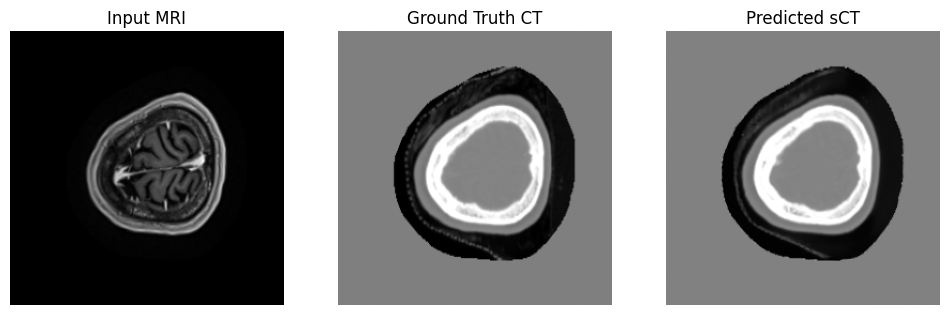

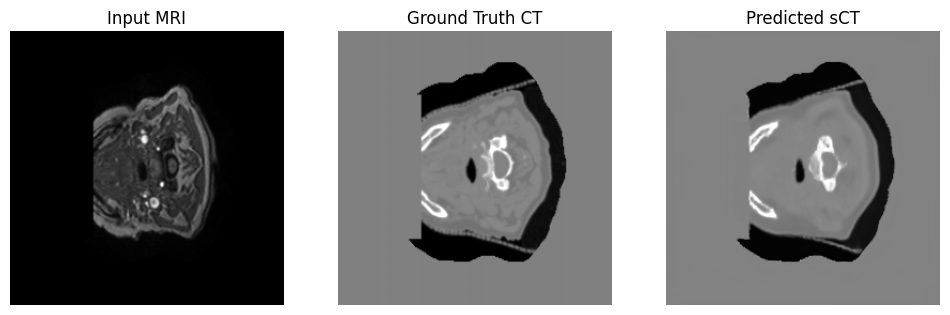

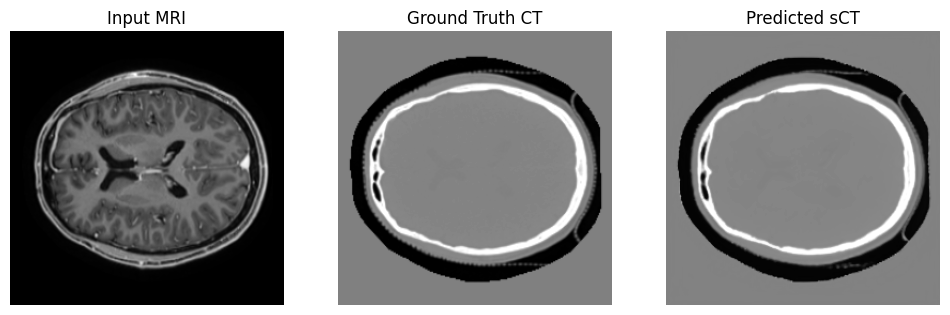

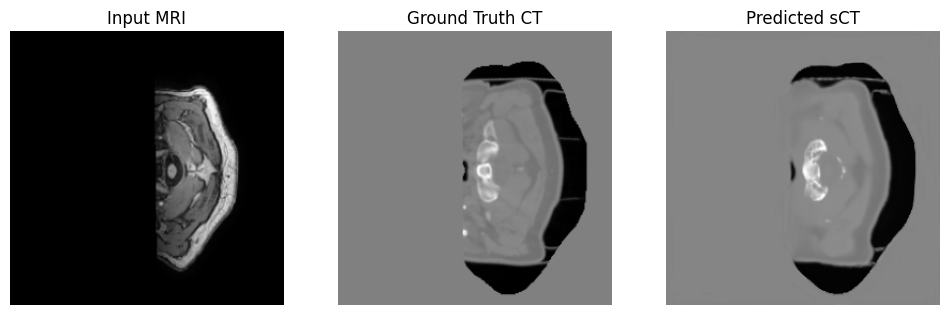

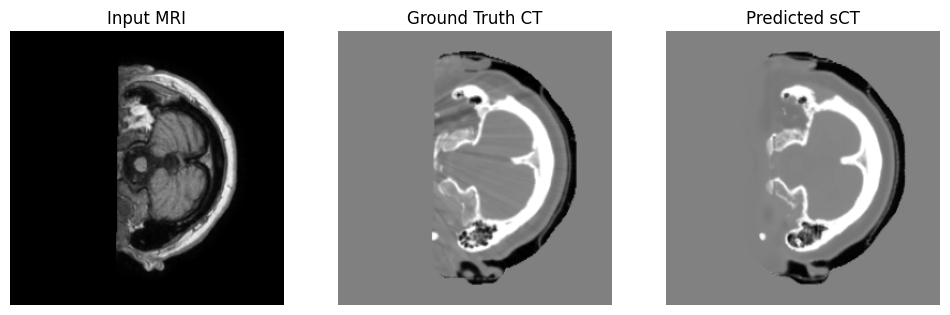

In [21]:
# assume generator is your trained Generator model
test_model(G, test_dl, device=device, num_samples=5)


In [23]:
import torch
import numpy as np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# ------------------------------
# Denormalization to HU
# ------------------------------
def denorm_to_hu(x, hu_min=-1000, hu_max=1000):
    x = (x + 1) / 2   # [-1,1] -> [0,1]
    return x * (hu_max - hu_min) + hu_min

# ------------------------------
# Batch-wise evaluation function
# ------------------------------
def evaluate_model(G, dataloader, device=device,hu_min=-1000, hu_max=1000):
    G.eval()
    psnr_vals, ssim_vals, mae_vals, mse_vals = [], [], [], []

    with torch.no_grad():
        for real_A, real_B in dataloader:  # MRI, CT
            real_A, real_B = real_A.to(device), real_B.to(device)
            
            # Generate predicted CT
            fake_B = G(real_A)
            
            # Denormalize batch to HU
            fake_B_hu = denorm_to_hu(fake_B).cpu().numpy()
            real_B_hu = denorm_to_hu(real_B).cpu().numpy()
            
            # Compute metrics slice by slice in batch
            batch_size = real_B_hu.shape[0]
            for i in range(batch_size):
                psnr_vals.append(
                    peak_signal_noise_ratio(
                        real_B_hu[i,0], fake_B_hu[i,0], data_range=hu_max - hu_min
                    )
                )
                ssim_vals.append(
                    structural_similarity(
                        real_B_hu[i,0], fake_B_hu[i,0], data_range=hu_max - hu_min
                    )
                )
                mae_vals.append(np.mean(np.abs(fake_B_hu[i,0] - real_B_hu[i,0])))
                mse_vals.append(np.mean((fake_B_hu[i,0] - real_B_hu[i,0]) ** 2))
    
    return {
        "PSNR (HU)": np.mean(psnr_vals),
        "SSIM": np.mean(ssim_vals),
        "MAE (HU)": np.mean(mae_vals),
        "MSE (HU^2)": np.mean(mse_vals)
    }

In [24]:
evaluate_model(G,test_dl)

{'PSNR (HU)': 33.35089334914672,
 'SSIM': 0.9404827248587826,
 'MAE (HU)': 16.053905,
 'MSE (HU^2)': 2164.9658}

In [ ]:
save_path2='checkpoints2'
os.makedirs(save_path2, exist_ok=True)

torch.save(
    {
        "epoch": epoch+1,
        "G_state_dict": G.state_dict(),
        "D_state_dict": D.state_dict(),
        "opt_G_state_dict": opt_G.state_dict(),
        "opt_D_state_dict": opt_D.state_dict(),
        "val_loss": best_val_loss,
    },
    os.path.join(save_path2, "best_model1.pth")
)


# **Training using Charbonnier loss**

In [28]:
# -----------------
# Define Charbonnier Loss
# -----------------
class CharbonnierLoss(nn.Module):
    def __init__(self, epsilon=1e-4):
        super(CharbonnierLoss, self).__init__()
        self.epsilon = epsilon

    def forward(self, x, y):
        diff = x - y
        loss = torch.mean(torch.sqrt(diff * diff + self.epsilon**2))
        return loss

In [29]:
#G = ResNetUNet(in_channels=1, out_channels=1).to(device)
#D = PatchDiscriminator(in_channels=2).to(device)

# Loss functions
criterion_GAN = nn.BCEWithLogitsLoss()
criterion_charb = CharbonnierLoss()   # using Charbonnier instead of L1

# optimizers
#opt_G = optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))
#opt_D = optim.Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.999))

In [30]:
# Initialize tracking
train_G_losses = []
train_D_losses = []
train_GAN_losses = []
train_char_losses = []
val_losses = []

epochs = 40
lambda_char = 50
best_val_loss = float("inf")  
save_path = "checkpoints3"
os.makedirs(save_path, exist_ok=True)

# Initialize W&B project
wandb.init(project="MRI-to-sCT", name="charbonnier-run")
wandb.config.update({
    "epochs": epochs,
    "lambda_char": lambda_char,
    "lr_G": opt_G.param_groups[0]["lr"],
    "lr_D": opt_D.param_groups[0]["lr"],
    "batch_size": train_dl.batch_size,
})

G.train()
D.train()

for epoch in range(epochs):
    # accumulators for this epoch
    epoch_G_loss = 0.0
    epoch_D_loss = 0.0
    epoch_GAN_loss = 0.0
    epoch_char_loss = 0.0
    num_batches = 0

    for i, (real_A, real_B) in enumerate(train_dl):  # MRI = real_A, sCT = real_B
        real_A, real_B = real_A.to(device), real_B.to(device)

        # -----------------
        # Train Generator
        # -----------------
        for _ in range(2):  # train G twice
            opt_G.zero_grad()
            fake_B = G(real_A)

            # GAN loss
            pred_fake = D(real_A, fake_B)
            valid = torch.ones_like(pred_fake, device=device)
            loss_GAN = criterion_GAN(pred_fake, valid)

            # Charbonnier reconstruction loss
            loss_charb = criterion_charb(fake_B, real_B) * lambda_char

            # total generator loss
            loss_G = loss_GAN + loss_charb
            loss_G.backward()
            opt_G.step()

        # -----------------
        # Train Discriminator
        # -----------------
        opt_D.zero_grad()

        # Real
        pred_real = D(real_A, real_B)
        loss_real = criterion_GAN(pred_real, valid)

        # Fake
        fake = torch.zeros_like(pred_real, device=device)
        pred_fake = D(real_A, fake_B.detach())
        loss_fake = criterion_GAN(pred_fake, fake)

        loss_D = 0.5 * (loss_real + loss_fake)
        loss_D.backward()
        opt_D.step()

        # accumulate losses
        epoch_G_loss += loss_G.item()
        epoch_D_loss += loss_D.item()
        epoch_GAN_loss += loss_GAN.item()
        epoch_char_loss += loss_charb.item()
        num_batches += 1

        if i % 100 == 0:
            print(f"[Epoch {epoch+1}/{epochs}] [Batch {i}/{len(train_dl)}] "
                  f"Loss_D: {loss_D.item():.4f} | Loss_G: {loss_G.item():.4f} "
                  f"(GAN: {loss_GAN.item():.4f}, Charb: {loss_charb.item():.4f})")

            #  log sample images to W&B
            wandb.log({
                "examples": [
                    wandb.Image(real_A[0].cpu(), caption="Input MRI"),
                    wandb.Image(real_B[0].cpu(), caption="Target sCT"),
                    wandb.Image(fake_B[0].detach().cpu(), caption="Generated sCT"),
                ]
            })

    # Average training losses per epoch
    epoch_G_loss /= num_batches
    epoch_D_loss /= num_batches
    epoch_GAN_loss /= num_batches
    epoch_char_loss /= num_batches

    train_G_losses.append(epoch_G_loss)
    train_D_losses.append(epoch_D_loss)
    train_GAN_losses.append(epoch_GAN_loss)
    train_char_losses.append(epoch_char_loss)

    # -----------------
    # Validation loop
    # -----------------
    G.eval()
    val_loss = 0.0
    with torch.no_grad():
        for real_A, real_B in val_dl:
            real_A, real_B = real_A.to(device), real_B.to(device)
            fake_B = G(real_A)
            val_loss += criterion_charb(fake_B, real_B).item()
    val_loss /= len(val_dl)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}: "
          f"Train_G: {epoch_G_loss:.4f}, Train_D: {epoch_D_loss:.4f}, "
          f"Val_Charb: {val_loss:.4f}")

    # log losses to W&B
    wandb.log({
        "train_G_loss": epoch_G_loss,
        "train_D_loss": epoch_D_loss,
        "train_GAN_loss": epoch_GAN_loss,
        "train_char_loss": epoch_char_loss,
        "val_loss": val_loss,
        "epoch": epoch + 1
    })

    # -----------------
    # Save best model checkpoint
    # -----------------
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(
            {
                "epoch": epoch+1,
                "G_state_dict": G.state_dict(),
                "D_state_dict": D.state_dict(),
                "opt_G_state_dict": opt_G.state_dict(),
                "opt_D_state_dict": opt_D.state_dict(),
                "val_loss": best_val_loss,
            },
            os.path.join(save_path, "pix2pix_charb_2-1.pth")
        )
        print(f"Saved best model at epoch {epoch+1} with val_loss {val_loss:.4f}")
        wandb.log({"best_val_loss": best_val_loss})

    G.train()

print("Training finished (with Charbonnier Loss + W&B tracking)")


[Epoch 1/40] [Batch 0/169] Loss_D: 0.6551 | Loss_G: 2.0234 (GAN: 1.2962, Charb: 0.7273)
[Epoch 1/40] [Batch 100/169] Loss_D: 0.6637 | Loss_G: 1.9243 (GAN: 1.2138, Charb: 0.7105)
Epoch 1: Train_G: 1.5332, Train_D: 0.6629, Val_Charb: 0.0164
Saved best model at epoch 1 with val_loss 0.0164
[Epoch 2/40] [Batch 0/169] Loss_D: 0.6933 | Loss_G: 1.2551 (GAN: 0.5023, Charb: 0.7528)
[Epoch 2/40] [Batch 100/169] Loss_D: 0.6119 | Loss_G: 1.7272 (GAN: 1.0162, Charb: 0.7110)
Epoch 2: Train_G: 1.5069, Train_D: 0.6626, Val_Charb: 0.0187
[Epoch 3/40] [Batch 0/169] Loss_D: 0.6363 | Loss_G: 1.7423 (GAN: 0.7556, Charb: 0.9866)
[Epoch 3/40] [Batch 100/169] Loss_D: 0.6820 | Loss_G: 1.3818 (GAN: 0.6535, Charb: 0.7283)
Epoch 3: Train_G: 1.4196, Train_D: 0.6943, Val_Charb: 0.0194
[Epoch 4/40] [Batch 0/169] Loss_D: 0.7146 | Loss_G: 1.4038 (GAN: 0.5611, Charb: 0.8427)
[Epoch 4/40] [Batch 100/169] Loss_D: 0.6748 | Loss_G: 1.3411 (GAN: 0.6280, Charb: 0.7131)
Epoch 4: Train_G: 1.4873, Train_D: 0.6593, Val_Charb: 0.

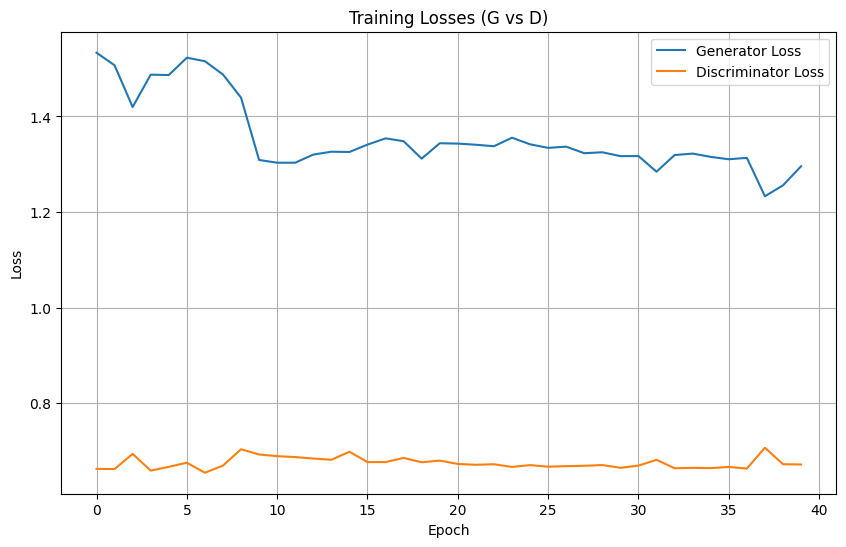

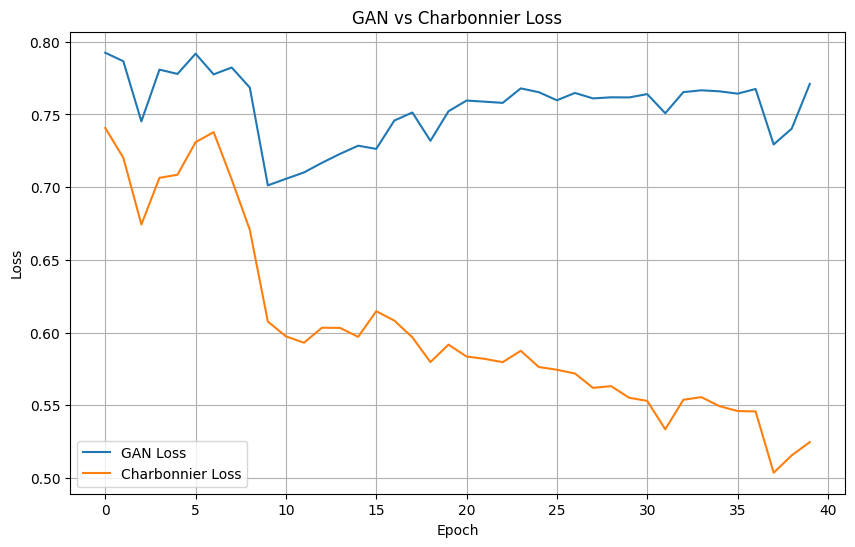

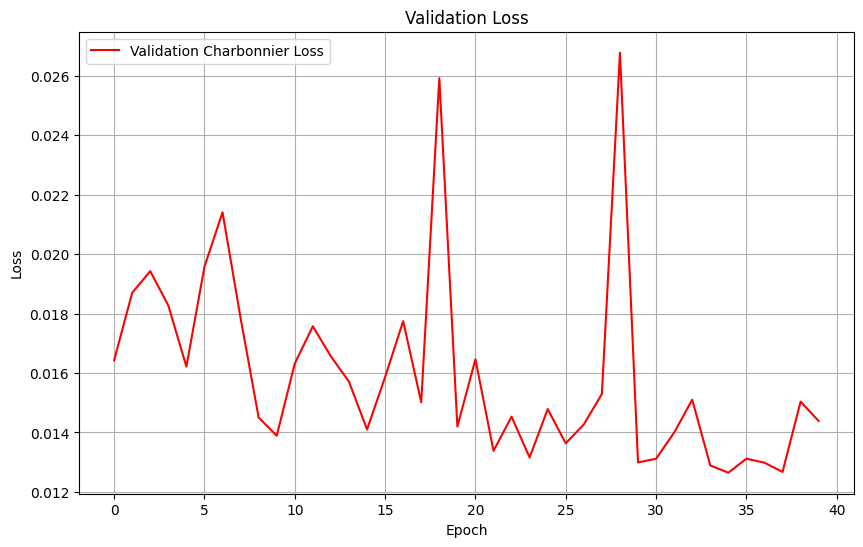

In [34]:
import matplotlib.pyplot as plt

# Plot Generator vs Discriminator losses
plt.figure(figsize=(10,6))
plt.plot(train_G_losses, label="Generator Loss")
plt.plot(train_D_losses, label="Discriminator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Losses (G vs D)")
plt.legend()
plt.grid(True)
plt.savefig("train_loss_G_D.png")  
plt.show()
plt.close()

# Plot GAN loss vs Charbonnier loss
plt.figure(figsize=(10,6))
plt.plot(train_GAN_losses, label="GAN Loss")
plt.plot(train_char_losses, label="Charbonnier Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("GAN vs Charbonnier Loss")
plt.legend()
plt.grid(True)
plt.savefig("train_loss_GAN_Charb.png")   
plt.show()
plt.close()

# Plot validation loss
plt.figure(figsize=(10,6))
plt.plot(val_losses, label="Validation Charbonnier Loss", color="red")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Validation Loss")
plt.legend()
plt.grid(True)
plt.savefig("val_loss.png")  
plt.show()
plt.close()


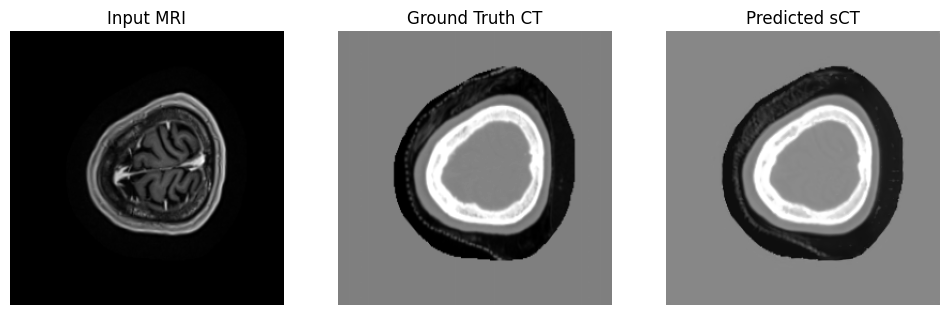

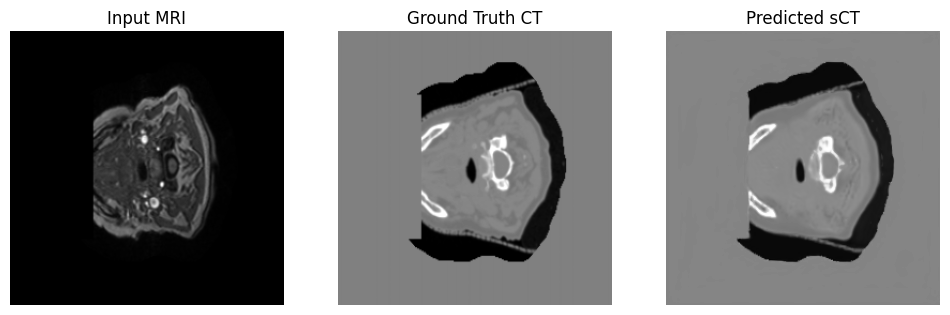

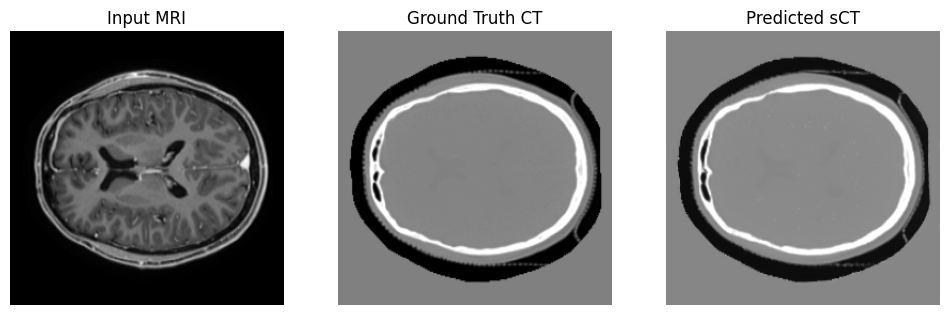

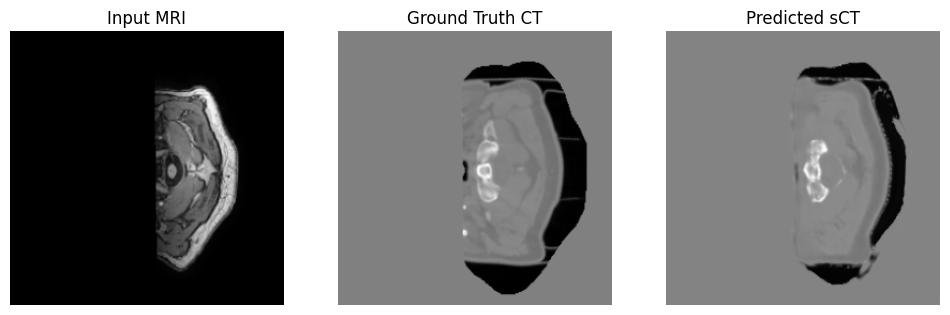

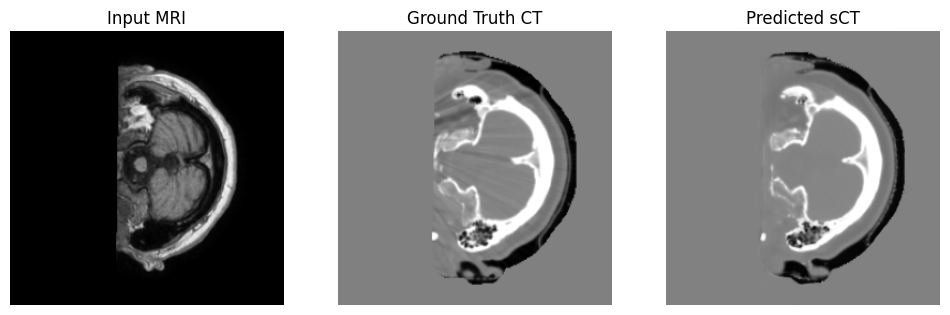

In [35]:
test_model(G, test_dl, device="cuda", num_samples=5)

In [36]:
evaluate_model(G,test_dl)

{'PSNR (HU)': 34.68300671615003,
 'SSIM': 0.9533191136660688,
 'MAE (HU)': 14.399291,
 'MSE (HU^2)': 1744.3062}

In [ ]:
save_path2='checkpoints4'
os.makedirs(save_path2, exist_ok=True)

torch.save(
    {
        "epoch": epoch+1,
        "G_state_dict": G.state_dict(),
        "D_state_dict": D.state_dict(),
        "opt_G_state_dict": opt_G.state_dict(),
        "opt_D_state_dict": opt_D.state_dict(),
        "val_loss": best_val_loss,
    },
    os.path.join(save_path2, "best_model.pth")
)
